In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

import os
import glob
import json
import random
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
idx_to_labels = {'0':'control', '1':'diabetic'}
transform = transforms.Compose([
 transforms.Resize((256, 256)),
#  transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Real: control
Predicted: control ( 0.9198053479194641 )


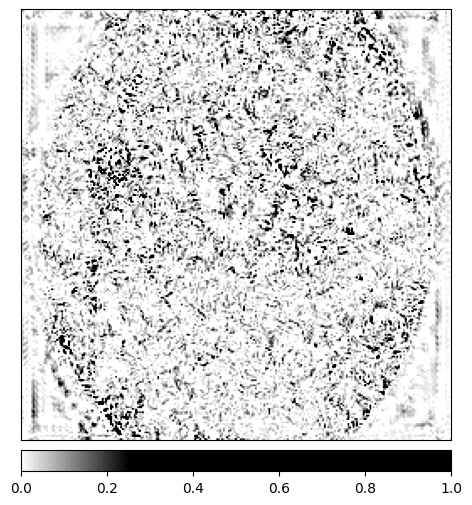

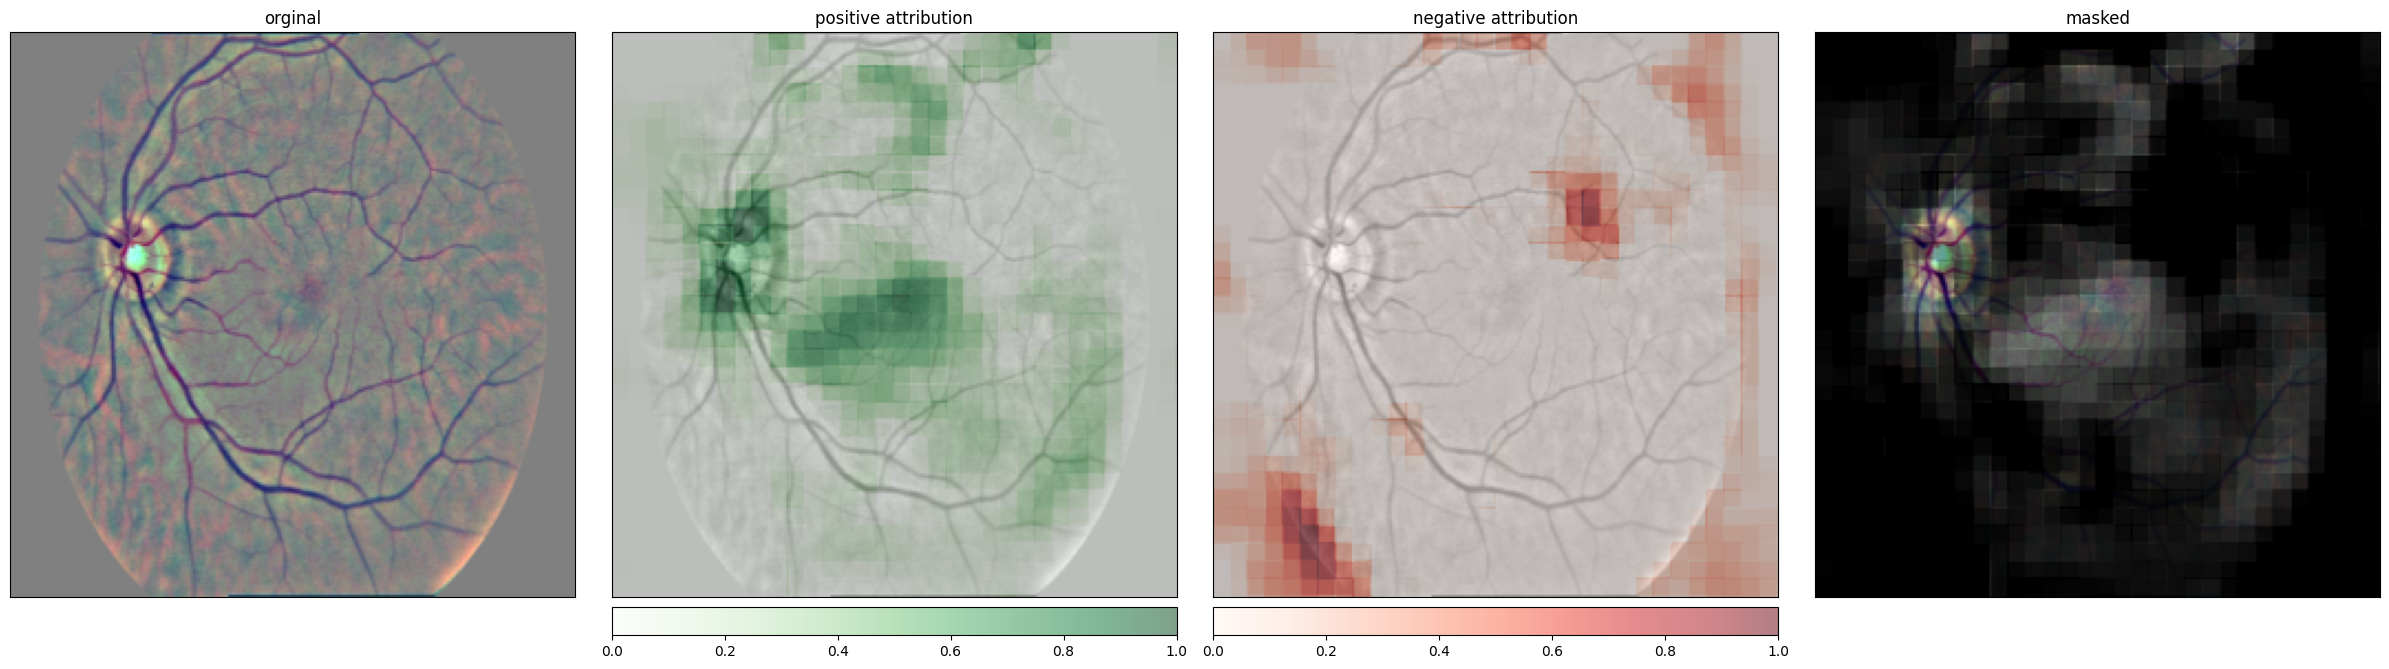

In [3]:
pathModel = "models/densenet_100epochs_data_norm_randomCropRotation.pt"

model = torchvision.models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
model = model.cuda()
model.load_state_dict(torch.load(pathModel))
model = model.eval()

img_path = random.choice(glob.glob('data/test/diabetic/*.png')+glob.glob('data/test/control/*.png'))
img = Image.open(img_path)
transformed_img = transform(img)
input = transform_normalize(transformed_img).unsqueeze(0).to(device)

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())]
print('Real: '+('control' if img_path.split('\\')[-1].split('.')[0].split('_')[1]=='c' else 'diabetic'))
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
torch.cuda.empty_cache()

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=5)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign="positive" if pred_label_idx.item() == 0 else 'negative',
                             outlier_perc=1)
noise_tunnel = NoiseTunnel(integrated_gradients)

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive" if pred_label_idx.item() == 0 else 'negative'],
                                      show_colorbar=True,
                                      titles=['orginal', 'positive attribution', 'negative attribution', 'masked'],
                                      outlier_perc=2,
                                      fig_size=(24,16)
                                     )

Real: diabetic
Predicted: diabetic ( 0.8266057968139648 )


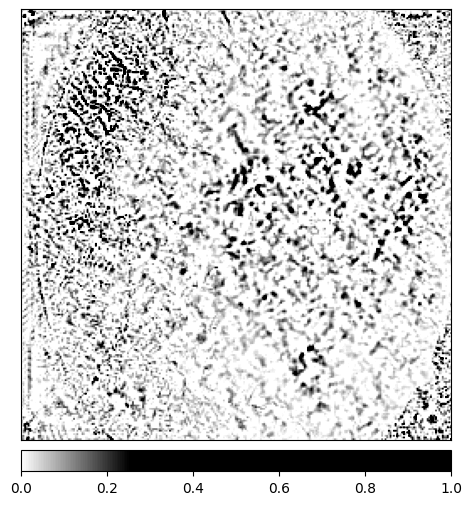

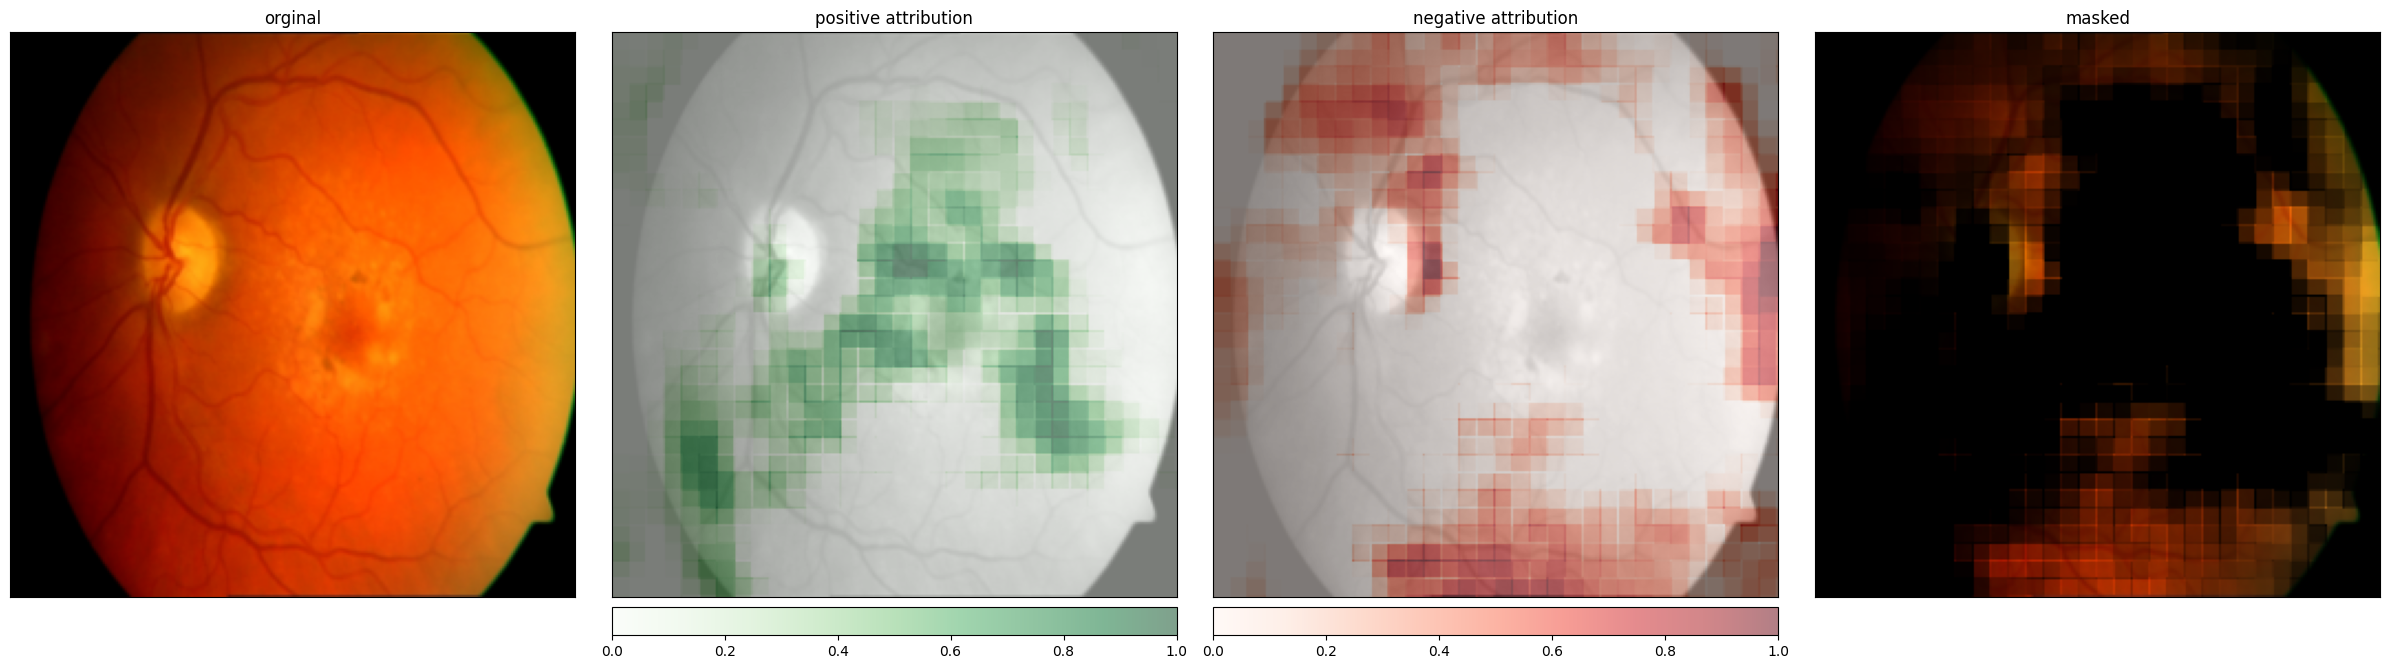

In [4]:
pathModel = "models/densenet_100epochs_data_raw_norm_randomCropRotation.pt"

model = torchvision.models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
model = model.cuda()
model.load_state_dict(torch.load(pathModel))
model = model.eval()

img_path = random.choice(glob.glob('data_raw/test/diabetic/*.tif')+glob.glob('data_raw/test/control/*.tif'))
img = Image.open(img_path)
transformed_img = transform(img)

input = transform_normalize(transformed_img).unsqueeze(0).to(device)

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())]
print('Real: '+('control' if img_path.split('\\')[-1].split('.')[0].split('_')[1]=='c' else 'diabetic'))
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
torch.cuda.empty_cache()

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=5)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign="positive" if pred_label_idx.item() == 0 else 'negative',
                             outlier_perc=1)
noise_tunnel = NoiseTunnel(integrated_gradients)

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive" if pred_label_idx.item() == 0 else 'negative'],
                                      show_colorbar=True,
                                      titles=['orginal', 'positive attribution', 'negative attribution', 'masked'],
                                      outlier_perc=2,
                                      fig_size=(24,16)
                                     )

Real: diabetic
Predicted: diabetic ( 0.8532030582427979 )


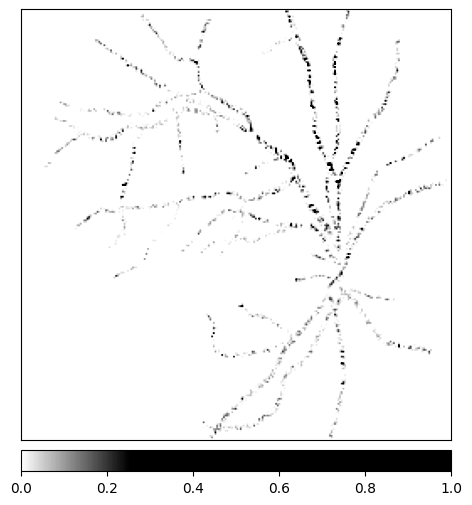

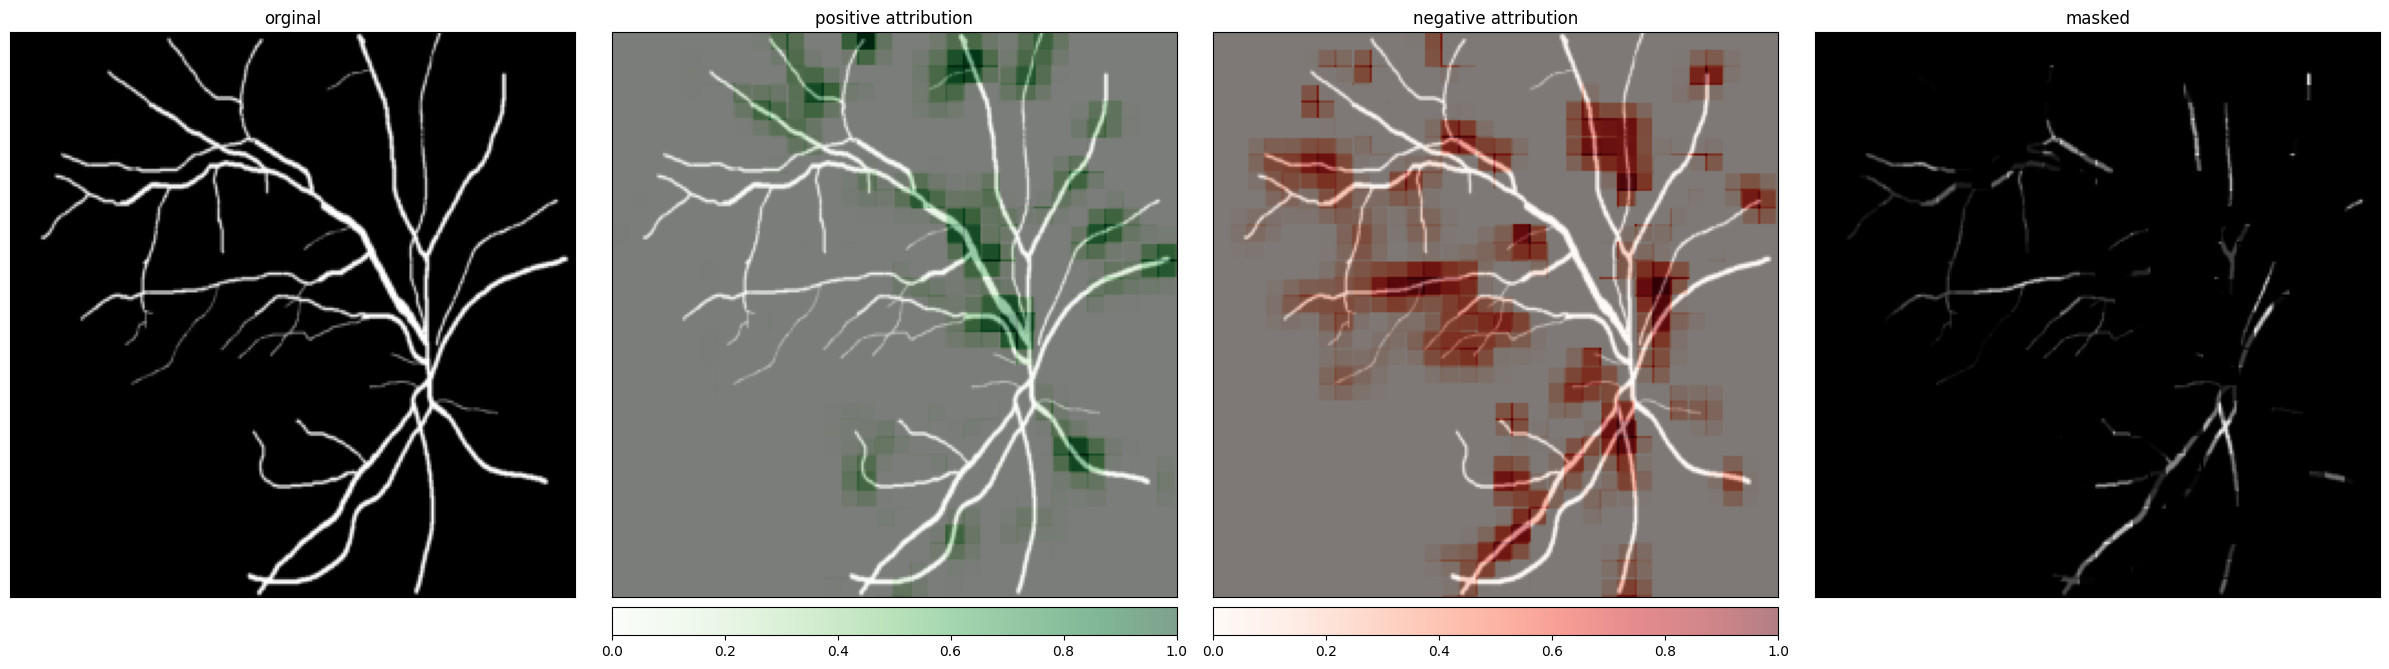

In [5]:
pathModel = "models/densenet_100epochs_data_vessel_randomCropRotation.pt"

model = torchvision.models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
model = model.cuda()
model.load_state_dict(torch.load(pathModel))
model = model.eval()

img_path = random.choice(glob.glob('data_vessel/test/diabetic/*.tif')+glob.glob('data_vessel/test/control/*.tif'))
img = Image.open(img_path)
transformed_img = transform(img)
transformed_img = transformed_img.expand(3,*transformed_img.shape[1:])

input = transformed_img.unsqueeze(0).to(device)

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())]
print('Real: '+('control' if img_path.split('\\')[-1].split('.')[0].split('_')[1]=='c' else 'diabetic'))
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
torch.cuda.empty_cache()

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=5)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign="positive" if pred_label_idx.item() == 0 else 'negative',
                             outlier_perc=1)
noise_tunnel = NoiseTunnel(integrated_gradients)

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive" if pred_label_idx.item() == 0 else 'negative'],
                                      show_colorbar=True,
                                      titles=['orginal', 'positive attribution', 'negative attribution', 'masked'],
                                      outlier_perc=2,
                                      fig_size=(24,16)
                                     )

In [7]:
# import os

# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms

# from captum.insights import AttributionVisualizer, Batch
# from captum.insights.attr_vis.features import ImageFeature
# def get_classes():
#     classes = [
#         "control",
#         "diabetic"
#     ]
#     return classes


# def get_pretrained_model():
#     pathModel = "models/densenet_100epochs_data_norm_randomCropRotation.pt"

#     model = torchvision.models.densenet121(pretrained=False)
#     num_ftrs = model.classifier.in_features
#     model.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
#     model = model.cuda()
#     model.load_state_dict(torch.load(pathModel))
    
#     return model


# def baseline_func(input):
#     return input * 0


# def formatted_data_iter():
#     dataset = torchvision.datasets.ImageFolder(
#         root="data/test", train=False, download=True, transform=transforms.ToTensor()
#     )
#     dataloader = iter(
#         torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)
#     )
#     while True:
#         images, labels = next(dataloader)
#         yield Batch(inputs=images, labels=labels)
        
# normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# model = get_pretrained_model()
# visualizer = AttributionVisualizer(
#     models=[model],
#     score_func=lambda o: torch.nn.functional.softmax(o, 1),
#     classes=get_classes(),
#     features=[
#         ImageFeature(
#             "Photo",
#             baseline_transforms=[baseline_func],
#             input_transforms=[normalize],
#         )
#     ],
#     dataset=formatted_data_iter(),
# )

# visualizer.render()